In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
# Dataset
import zipfile

z = zipfile.ZipFile('/content/archive.zip')

z.extractall()

In [5]:
folder = '/content/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [6]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [7]:
# EDA(Exploratory Data Analysis)

In [8]:
listyes = os.listdir("/content/brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("/content/brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


In [9]:
# Plot

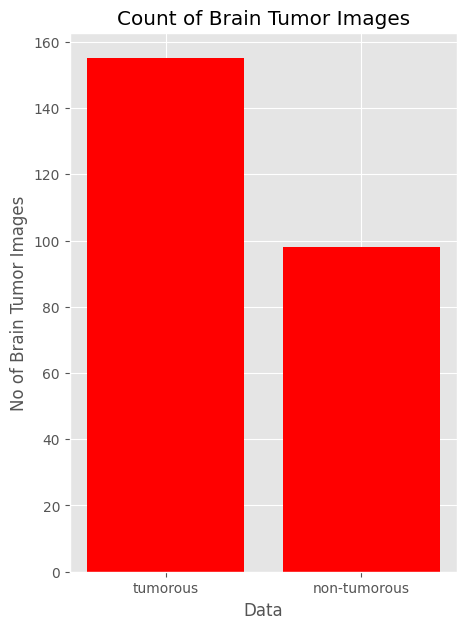

In [10]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [11]:
# Data Augmentation
# 155(61%), 98(39%)
# imbalance

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [14]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [15]:
import time
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# ... other import statements and function definitions ...

start_time = time.time()

yes_path = '/content/brain_tumor_dataset/yes'
no_path = '/content/brain_tumor_dataset/no'

augmented_data_path = '/content/augmented_data/'

# Create the directories if they don't exist
os.makedirs(augmented_data_path + 'yes', exist_ok=True)
os.makedirs(augmented_data_path + 'no', exist_ok=True)

augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + 'yes')
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:27.083465814590454


In [16]:
def data_summary(main_path):
    yes_path = "/content/augmented_data/yes/"
    no_path = "/content/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [17]:
data_summary(augmented_data_path)

Number of sample: 2065
1085 Number of positive sample in percentage: 52.54237288135593%
980 Number of negative sample in percentage: 47.45762711864407%


In [18]:
listyes = os.listdir("/content/augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("/content/augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
980


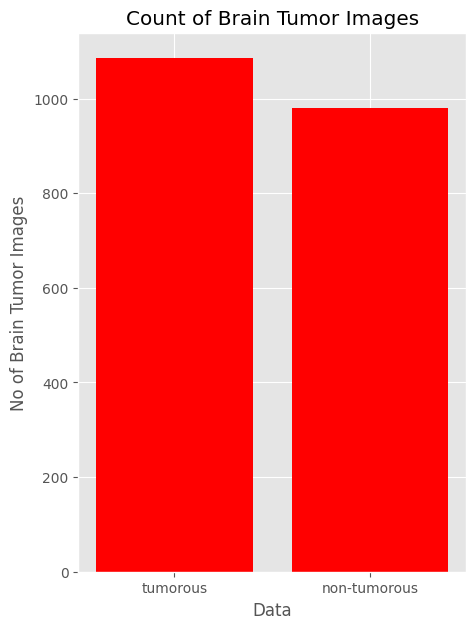

In [19]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [20]:
# Data Preprocessing

In [21]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [22]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


In [23]:
# img = cv2.imread('/content/augmented_data/yes/aug_Y_101_0_2036.jpg')
# crop_brain_tumor(img, True)

In [24]:
# img = cv2.imread('/content/augmented_data/no/aug_N_10_0_4352.jpg')
# crop_brain_tumor(img, True)

In [25]:
folder1 = '/content/augmented_data/no/'
folder2 = '/content/augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [26]:
# image loading

In [27]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [28]:
augmented_path = '/content/augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)


In [29]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

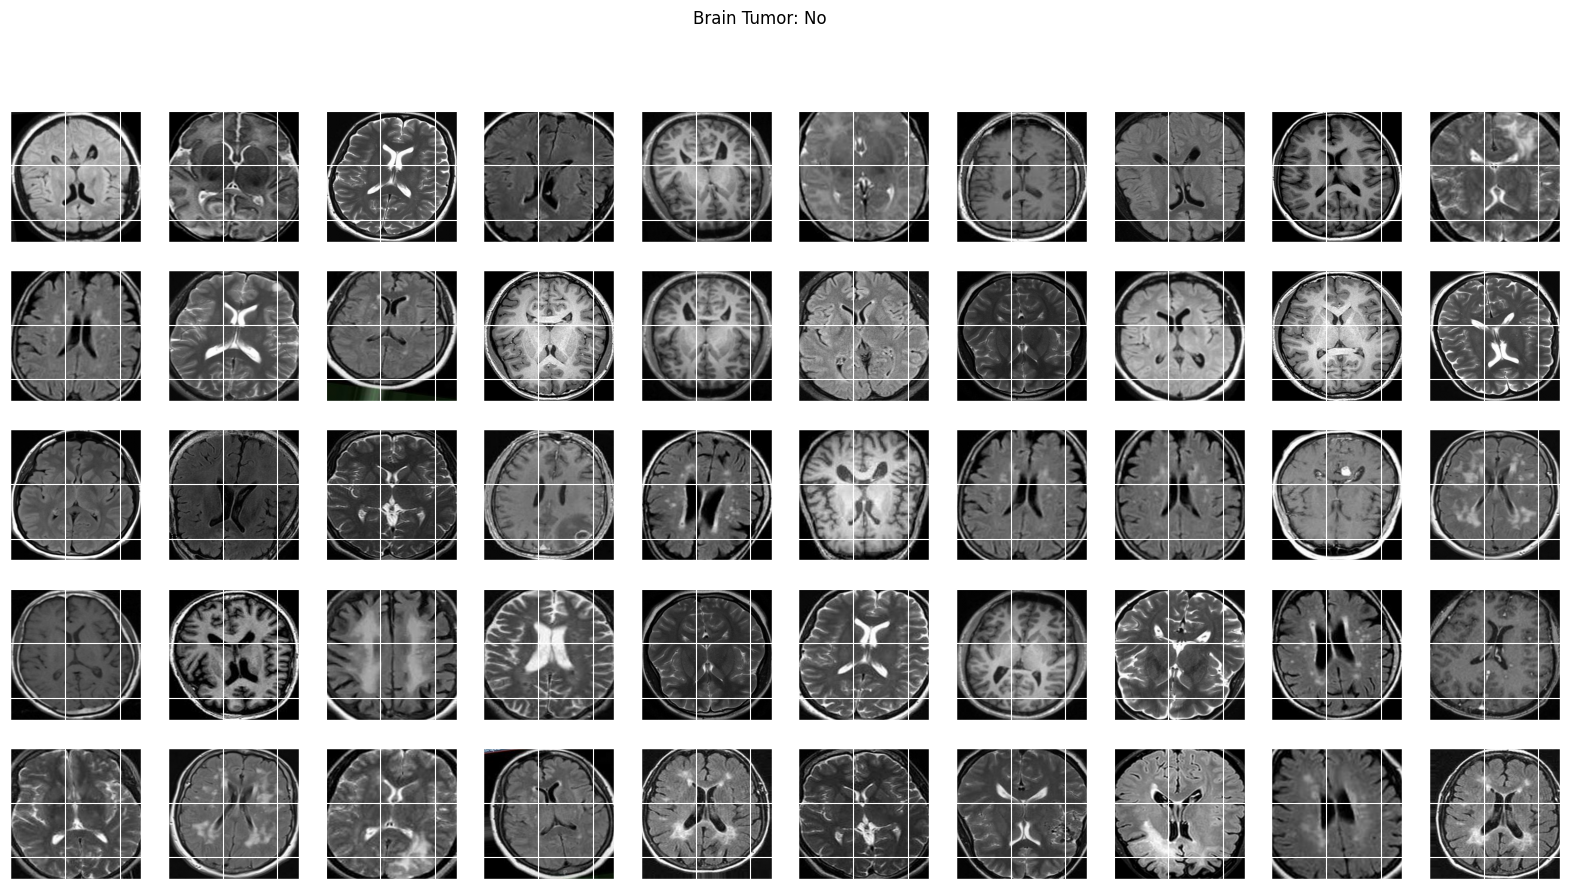

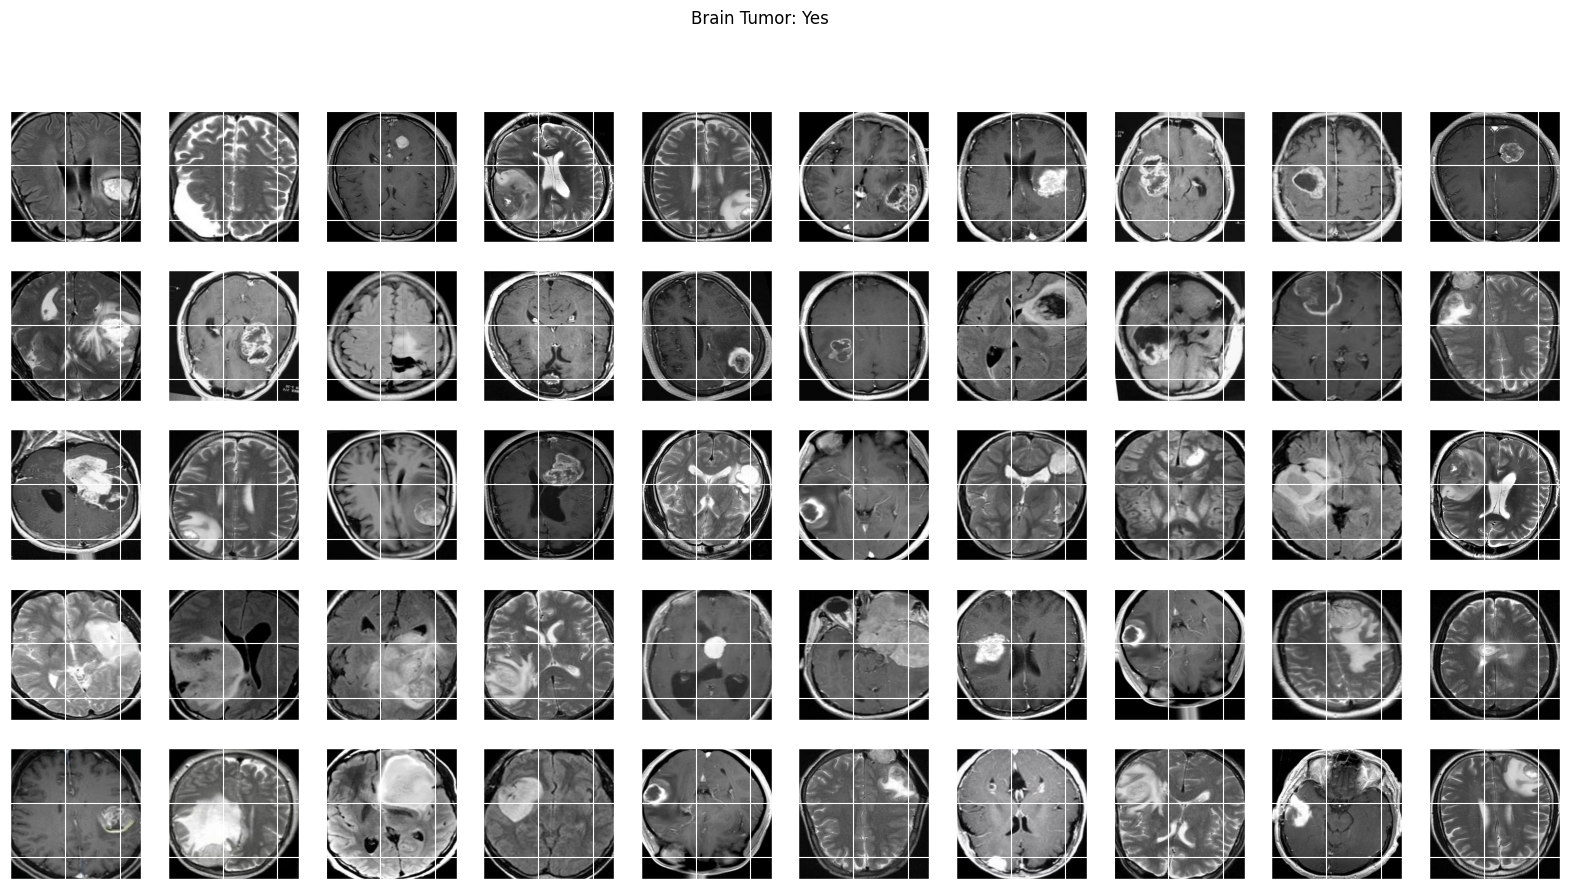

In [30]:
plot_sample_images(X,y)

In [31]:
# Data Spliting
# Train
# Test
# Validation

In [32]:
if not os.path.isdir('/content/tumorous_and_nontumorous'):
    base_dir = '/content/tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [33]:
if not os.path.isdir('/content/tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [34]:
if not os.path.isdir('/content/tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [35]:
if not os.path.isdir('/content/tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('/content/tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [36]:
original_dataset_tumorours = os.path.join('/content/augmented_data','yes/')
original_dataset_nontumorours = os.path.join('/content/augmented_data','no/')

In [37]:
files = os.listdir('/content/augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [38]:
files = os.listdir('/content/augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [39]:
files = os.listdir('/content/augmented_data/yes/')
fnames = []
for i in range(922,1083):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [40]:
# 80% 10% 10%

In [41]:
files = os.listdir('/content/augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [42]:
files = os.listdir('/content/augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [43]:
files = os.listdir('/content/augmented_data/no/')
fnames = []
for i in range(833,978):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [44]:
# Model Buliding

In [45]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [46]:
train_generator = train_datagen.flow_from_directory('/content/tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [47]:
test_generator = train_datagen.flow_from_directory('/content/tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [48]:
valid_generator = train_datagen.flow_from_directory('/content/tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 306 images belonging to 2 classes.


In [49]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [50]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [51]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [52]:
# callback
filepath = '/content/model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [53]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [54]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4487 - loss: 0.7739
Epoch 1: val_loss improved from inf to 0.69572, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4517 - loss: 0.7722 - val_accuracy: 0.5261 - val_loss: 0.6957 - learning_rate: 1.0000e-04
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5262 - loss: 0.7321
Epoch 2: val_loss improved from 0.69572 to 0.68887, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5281 - loss: 0.7303 - val_accuracy: 0.5065 - val_loss: 0.6889 - learning_rate: 1.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5807 - loss: 0.6778
Epoch 3: val_loss improved from 0.68887 to 0.66314, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5765 - loss: 0.6794 - val_accuracy: 0.6176 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.5549 - loss: 0.6995
Epoch 4: val_loss improved from 0.66314 to 0.64846, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5553 - loss: 0.6987 - val_accuracy: 0.6111 - val_loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 5/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6704 - loss: 0.6461

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss did not improve from 0.64846
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.6585 - loss: 0.6507 - val_accuracy: 0.6144 - val_loss: 0.6580 - learning_rate: 1.0000e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6275 - loss: 0.6653
Epoch 6: val_loss improved from 0.64846 to 0.64276, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.6247 - loss: 0.6657 - val_accuracy: 0.6569 - val_loss: 0.6428 - learning_rate: 1.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5717 - loss: 0.6902
Epoch 7: val_loss improved from 0.64276 to 0.61667, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.5740 - loss: 0.6881 - val_accuracy: 0.6797 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6599 - loss: 0.6380
Epoch 8: val_loss did not improve from 0.61667
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6595 - loss: 0.6378 - val_accuracy: 0.6503 - val_loss: 0.6332 - learning_rate: 1.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6004 - loss: 0.6703
Epoch 9: val_loss did not improve from 0.61667
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6035 - loss: 0.6684 - val_accuracy: 0.6242 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 10/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6466 - loss: 0.6452
Epoch 10: val_loss did not improve from 0.61667
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step - accuracy: 0.6401 - loss: 0.6422 - val_accuracy: 0.6046 - val_loss: 0.6536 - learning_rate: 1.0000e-04


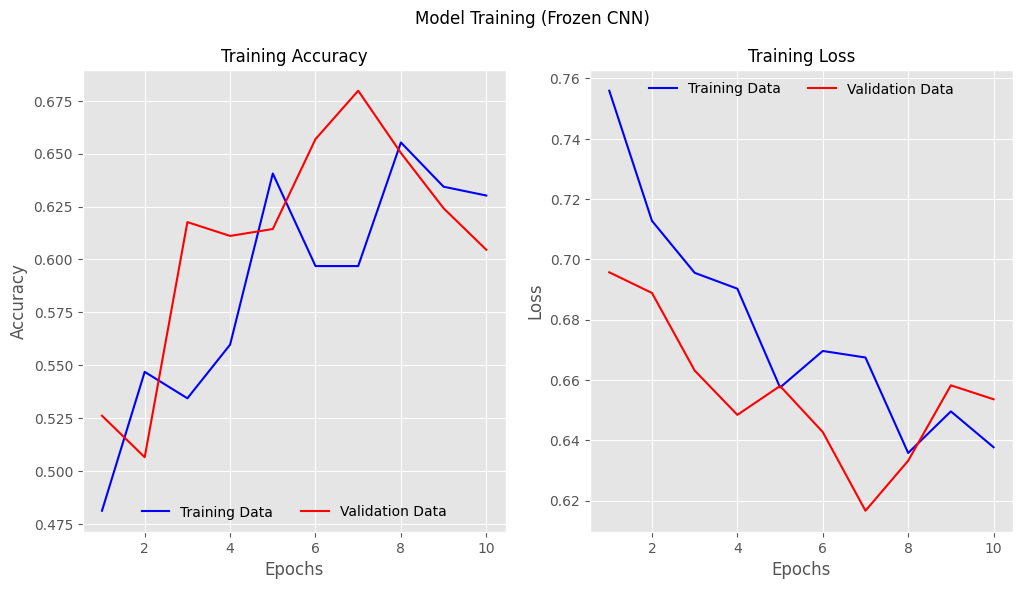

In [55]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [56]:
if not os.path.isdir('/content/model_weights/'):
    os.mkdir('/content/model_weights/')
model_01.save_weights(filepath="/content/model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [57]:
model_01.load_weights("/content/model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.5882 - loss: 0.6545


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6098 - loss: 0.6470


In [58]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6536865234375
Validation Acc: 0.584967315196991
Testing Loss: 0.6511395573616028
Testing Acc: 0.5870967507362366


In [59]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [60]:
# Increamental unfreezing and fine tuning

In [61]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [62]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('/content/model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [63]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [64]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_49']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.6377 - loss: 0.6340
Epoch 1: val_loss did not improve from 0.61667
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6363 - loss: 0.6337 - val_accuracy: 0.6503 - val_loss: 0.6306 - learning_rate: 1.0000e-04
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6109 - loss: 0.6414
Epoch 2: val_loss did not improve from 0.61667
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6093 - loss: 0.6437 - val_accuracy: 0.6307 - val_loss: 0.6184 - learning_rate: 1.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5654 - loss: 0.6999
Epoch 3: val_loss improved from 0.61667 to 0.60107, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.5668 - loss: 0.6975 - val_accuracy: 0.6634 - val_loss: 0.6011 - learning_rate: 1.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5898 - loss: 0.6516
Epoch 4: val_loss improved from 0.60107 to 0.59898, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.5911 - loss: 0.6519 - val_accuracy: 0.6569 - val_loss: 0.5990 - learning_rate: 1.0000e-04
Epoch 5/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.6616 - loss: 0.6050
Epoch 5: val_loss did not improve from 0.59898
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step - accuracy: 0.6553 - loss: 0.6141 - val_accuracy: 0.6895 - val_loss: 0.6003 - learning_rate: 1.0000e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.5955 - loss: 0.6398
Epoch 6: val_loss did not improve from 0.59898
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5953 - loss: 0.6409 - val_accuracy: 0.6340 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6186 - loss: 0.6607
Epoch 7: val_loss did not improve from 0.59898
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6206 - loss: 0.6593 - val_accuracy: 0.6863 - val_loss: 0.6044 - learning_rate: 1.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.6363 - loss: 0.6219 - val_accuracy: 0.7092 - val_loss: 0.5931 - learning_rate: 1.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6317 - loss: 0.6396
Epoch 9: val_loss did not improve from 0.59309
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6319 - loss: 0.6404 - val_accuracy: 0.6732 - val_loss: 0.5942 - learning_rate: 1.0000e-04
Epoch 10/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7030 - loss: 0.5999
Epoch 10: val_loss did not improve from 0.59309
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 669ms/step - accuracy: 0.6843 - loss: 0.6120 - val_accuracy: 0.6569 - val_loss: 0.6034 - learning_rate: 1.0000e-04


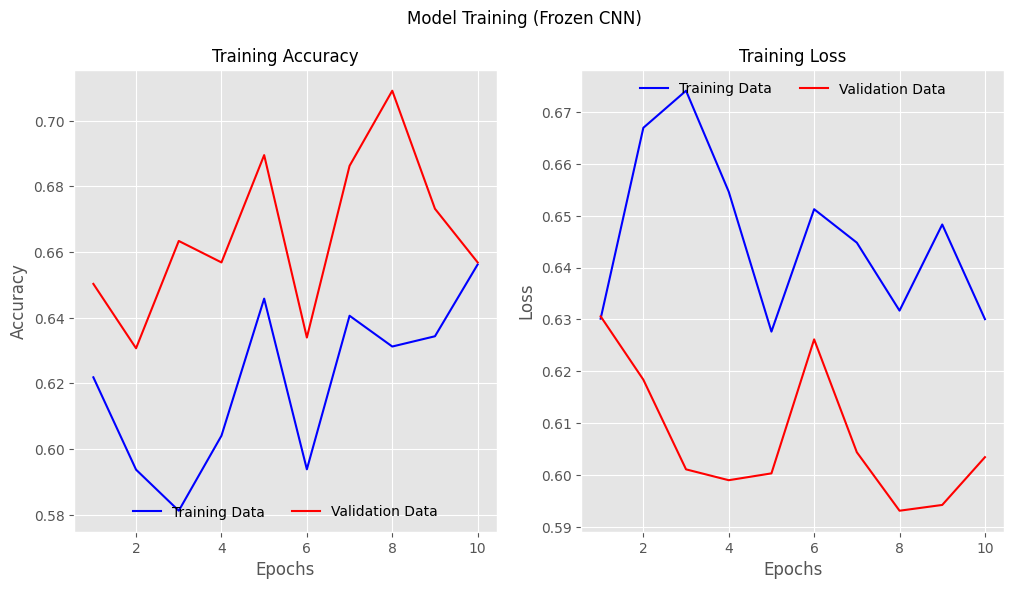

In [65]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
# The error is here. epochs_list was generated from history_01 but used with data from history_02
# max_epoch = len(history_01.history['accuracy'])+1
# Use the correct history object for generating epochs_list
max_epoch = len(history_02.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [66]:
if not os.path.isdir('/content/model_weights/'):
    os.mkdir('/content/model_weights/')
model_02.save_weights(filepath="/content/model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [67]:
model_02.load_weights("/content/model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 621ms/step - accuracy: 0.6473 - loss: 0.5912
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.7119 - loss: 0.5733


In [68]:
# Unfreezing the entire network

In [69]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('/content/model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [70]:
model_03.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 15, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.6850 - loss: 0.6082
Epoch 1: val_loss improved from 0.59309 to 0.58817, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 7s/step - accuracy: 0.6838 - loss: 0.6081 - val_accuracy: 0.7059 - val_loss: 0.5882 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6894 - loss: 0.5832
Epoch 2: val_loss improved from 0.58817 to 0.56394, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.6872 - loss: 0.5843 - val_accuracy: 0.7288 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6815 - loss: 0.5923
Epoch 3: val_loss improved from 0.56394 to 0.56073, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.6824 - loss: 0.5923 - val_accuracy: 0.7255 - val_loss: 0.5607 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6842 - loss: 0.5924
Epoch 4: val_loss did not improve from 0.56073
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6837 - loss: 0.5915 - val_accuracy: 0.6961 - val_loss: 0.5660 - learning_rate: 1.0000e-04
Epoch 5/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.6451 - loss: 0.6043

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss improved from 0.56073 to 0.55898, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.6558 - loss: 0.6061 - val_accuracy: 0.7124 - val_loss: 0.5590 - learning_rate: 1.0000e-04
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7221 - loss: 0.5903
Epoch 6: val_loss improved from 0.55898 to 0.54698, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.7210 - loss: 0.5895 - val_accuracy: 0.7549 - val_loss: 0.5470 - learning_rate: 1.0000e-04
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.7404 - loss: 0.5372
Epoch 7: val_loss improved from 0.54698 to 0.52824, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.7376 - loss: 0.5403 - val_accuracy: 0.7516 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7018 - loss: 0.5731
Epoch 8: val_loss did not improve from 0.52824
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7028 - loss: 0.5714 - val_accuracy: 0.7190 - val_loss: 0.5329 - learning_rate: 1.0000e-04
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.7855 - loss: 0.4993
Epoch 9: val_loss improved from 0.52824 to 0.49335, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7843 - loss: 0.5005 - val_accuracy: 0.7712 - val_loss: 0.4934 - learning_rate: 1.0000e-04
Epoch 10/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.7295 - loss: 0.5306
Epoch 10: val_loss did not improve from 0.49335
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 921ms/step - accuracy: 0.7252 - loss: 0.5381 - val_accuracy: 0.7549 - val_loss: 0.5067 - learning_rate: 1.0000e-04
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.7628 - loss: 0.5017
Epoch 11: val_loss improved from 0.49335 to 0.48695, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7639 - loss: 0.5012 - val_accuracy: 0.7614 - val_loss: 0.4869 - learning_rate: 1.0000e-04
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7090 - loss: 0.5080
Epoch 12: val_loss improved from 0.48695 to 0.46826, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.7093 - loss: 0.5079 - val_accuracy: 0.8007 - val_loss: 0.4683 - learning_rate: 1.0000e-04
Epoch 13/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8077 - loss: 0.4626
Epoch 13: val_loss improved from 0.46826 to 0.44842, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8081 - loss: 0.4614 - val_accuracy: 0.8137 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 14/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7581 - loss: 0.5009
Epoch 14: val_loss improved from 0.44842 to 0.41391, saving model to /content/model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.7588 - loss: 0.5002 - val_accuracy: 0.8007 - val_loss: 0.4139 - learning_rate: 1.0000e-04
Epoch 15/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - accuracy: 0.7543 - loss: 0.4873
Epoch 15: val_loss did not improve from 0.41391
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 908ms/step - accuracy: 0.7692 - loss: 0.4773 - val_accuracy: 0.8203 - val_loss: 0.4209 - learning_rate: 1.0000e-04


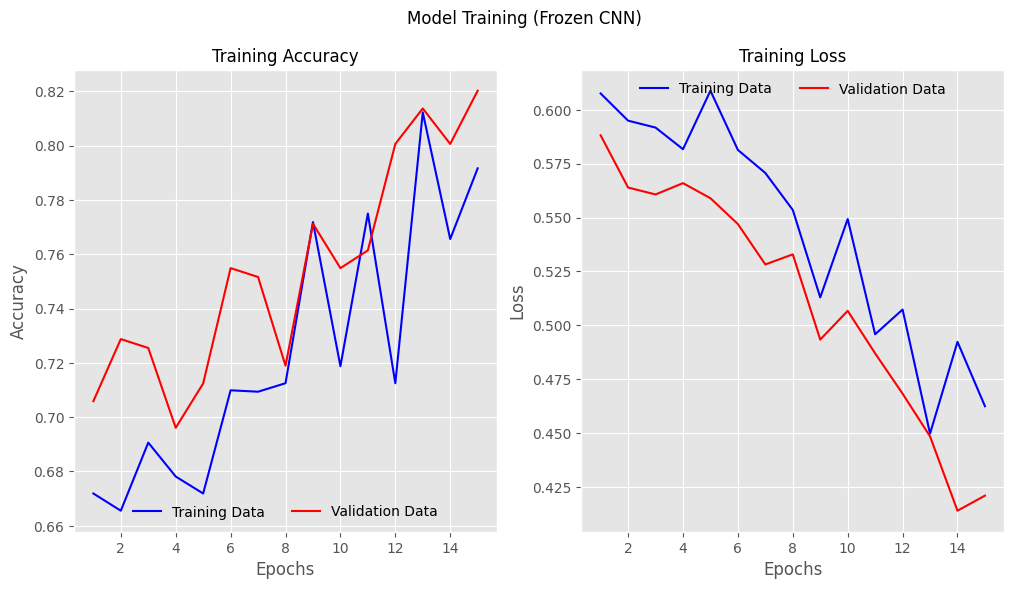

In [75]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
# The error is here. epochs_list was generated from history_01 but used with data from history_02
# max_epoch = len(history_01.history['accuracy'])+1
# Use the correct history object for generating epochs_list
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [72]:
if not os.path.isdir('/content/model_weights/'):
    os.mkdir('/content/model_weights/')
model_03.save_weights(filepath="/content/model_weights/vgg19_model_03.weights.h5", overwrite=True)

In [73]:
model_03.load_weights("/content/model_weights/vgg19_model_03.weights.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.8345 - loss: 0.4081
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - accuracy: 0.8641 - loss: 0.3964


In [74]:
# Google Colab